<a href="https://colab.research.google.com/github/RaniaSaeed01/IE423-Tasks/blob/main/Final_Rania_Saeed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dfShoppers = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/online_shoppers_intention.csv')

In [4]:
dfShoppers.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


# **Exploratory Data Analysis (EDA)**

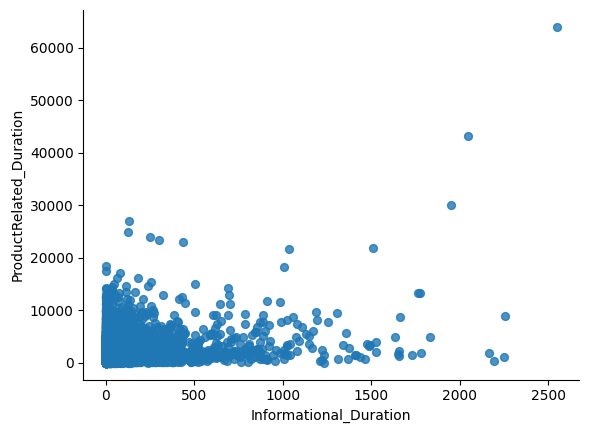

In [11]:
dfShoppers.plot(kind='scatter', x='Informational_Duration', y='ProductRelated_Duration', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Customers tend to spend more time on product related pages than informational pages.

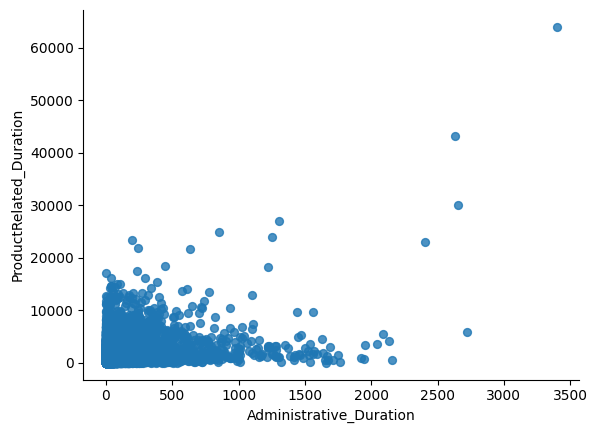

In [12]:
dfShoppers.plot(kind='scatter', x='Administrative_Duration', y='ProductRelated_Duration', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Customers tend to spend more time product related pages than informational pages

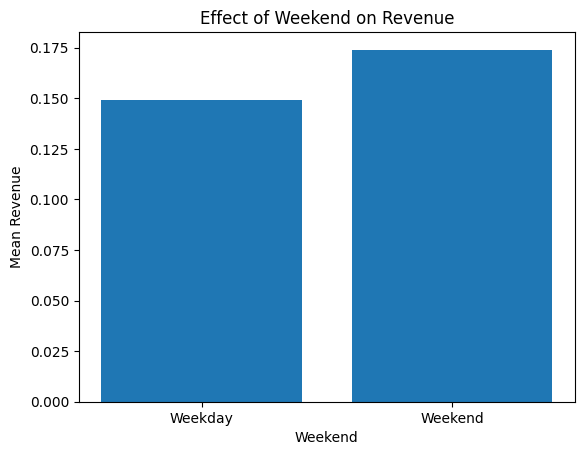

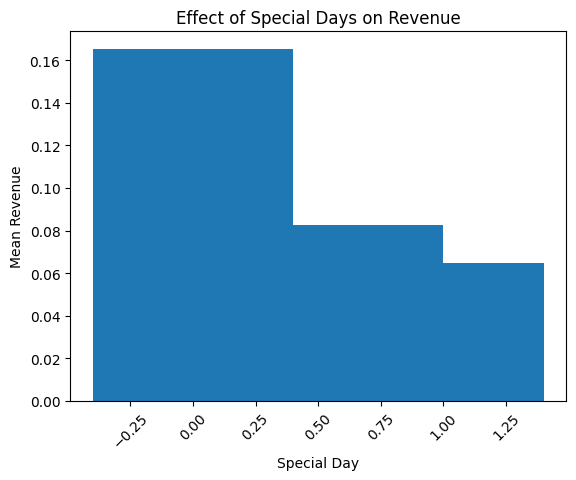

In [39]:
# Group the data by 'Weekend' and calculate the mean revenue for each group
weekend_revenue = dfShoppers.groupby('Weekend')['Revenue'].mean()

# Create a bar plot
plt.bar(weekend_revenue.index, weekend_revenue.values)
plt.xlabel('Weekend')
plt.ylabel('Mean Revenue')
plt.title('Effect of Weekend on Revenue')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()

# Group the data by 'SpecialDay' and calculate the mean revenue for each group
specialday_revenue = dfShoppers.groupby('SpecialDay')['Revenue'].mean()

# Create a bar plot
plt.bar(specialday_revenue.index, specialday_revenue.values)
plt.xlabel('Special Day')
plt.ylabel('Mean Revenue')
plt.title('Effect of Special Days on Revenue')
plt.xticks(rotation=45)
plt.show()


Shoppers are more likely to make the purchase on weekends and closer to special days.

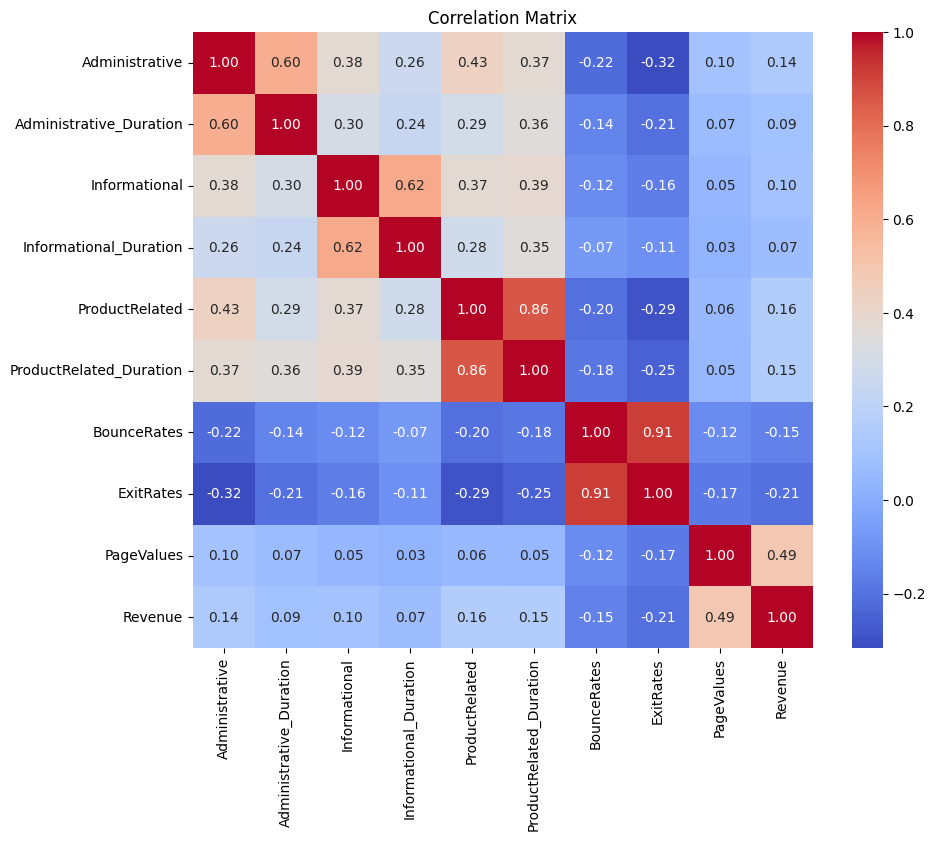

In [40]:
# Calculate the correlation matrix
correlation_matrix = dfShoppers[['Administrative', 'Administrative_Duration', 'Informational',
                                 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                                 'BounceRates', 'ExitRates', 'PageValues', 'Revenue']].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


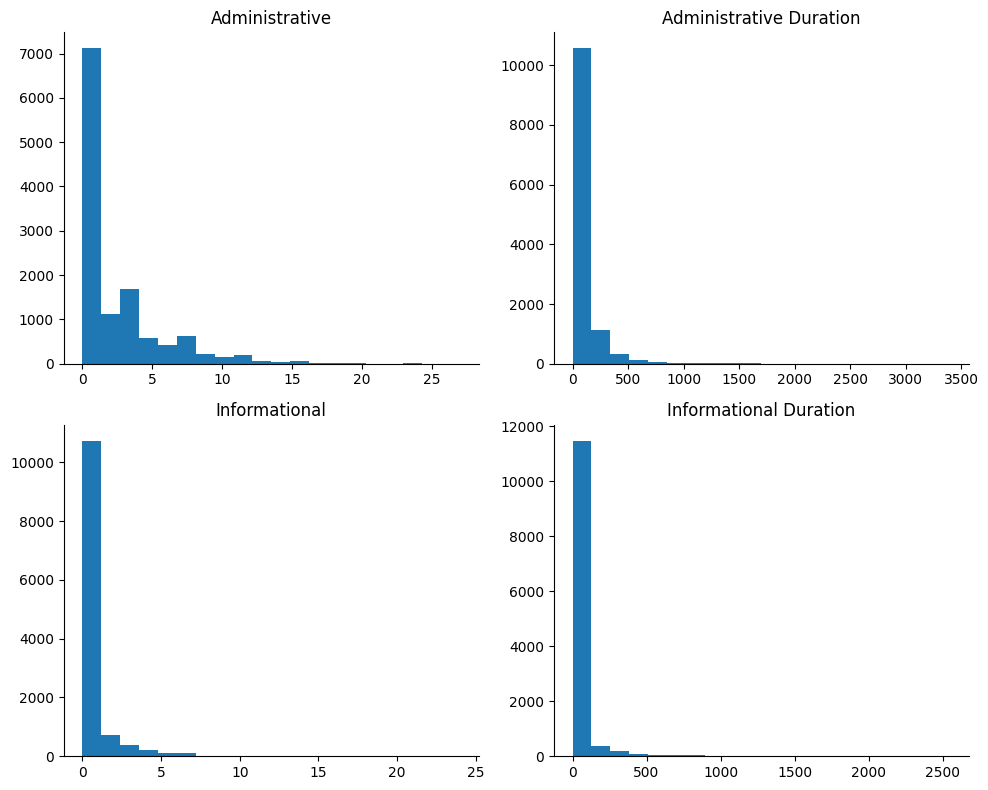

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Administrative
axes[0, 0].hist(dfShoppers['Administrative'], bins=20)
axes[0, 0].set_title('Administrative')
axes[0, 0].spines[['top', 'right']].set_visible(False)

# Administrative Duration
axes[0, 1].hist(dfShoppers['Administrative_Duration'], bins=20)
axes[0, 1].set_title('Administrative Duration')
axes[0, 1].spines[['top', 'right']].set_visible(False)

# Informational
axes[1, 0].hist(dfShoppers['Informational'], bins=20)
axes[1, 0].set_title('Informational')
axes[1, 0].spines[['top', 'right']].set_visible(False)

# Informational Duration
axes[1, 1].hist(dfShoppers['Informational_Duration'], bins=20)
axes[1, 1].set_title('Informational Duration')
axes[1, 1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()


Most online shoppers spent little to no amount of time browsing pages account or information related pages. This may be due to a lack of interest or lack of understanding about how to visit these pages. Perhaps improving the user experience and content on these pages could lead to increased engagement and potentially higher conversions.

# **Data Preprocessing**

In [13]:
# Select numeric features
cols_num = [col for col in dfShoppers.columns if dfShoppers[col].dtype in ['int64', 'float64']]
Xnum = dfShoppers[cols_num]
#Checking for null values
print('Numerical features and their corresponding count of null values:')
Xnum.isna().sum()

Numerical features and their corresponding count of null values:


,0
Administrative,0
Administrative_Duration,0
Informational,0
Informational_Duration,0
ProductRelated,0
ProductRelated_Duration,0
BounceRates,0
ExitRates,0
PageValues,0
SpecialDay,0


In [14]:
cols_bool = [col for col in dfShoppers.columns if dfShoppers[col].dtype == 'bool']
Xbool = dfShoppers[cols_bool]
#cols_obj

print('Boolean features and their corresponding count of null values:')
Xbool.isna().sum()

Boolean features and their corresponding count of null values:


,0
Weekend,0
Revenue,0


In [15]:
cols_obj = [col for col in dfShoppers.columns if dfShoppers[col].dtype == 'object']
Xobj = dfShoppers[cols_obj]
#cols_obj

print('Categorical features and their corresponding count of null values:')
Xobj.isna().sum()

Categorical features and their corresponding count of null values:


,0
Month,0
VisitorType,0


In [16]:
# Initialize LabelEncoder
le = LabelEncoder()

# New DataFrame to store encoded features
Xobj_encoded = pd.DataFrame()

# Iterate through categorical columns and encode them
for col in Xobj.columns:
  Xobj_encoded[col] = le.fit_transform(Xobj[col])

# Concatenate numerical, boolean, and encoded categorical features
dfShoppers_encoded = pd.concat([Xnum, Xbool, Xobj_encoded], axis=1)

# Display the new dataset with encoded features
dfShoppers_encoded.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,Month,VisitorType
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,1,1,1,1,False,False,2,2
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,1,2,False,False,2,2
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,4,1,9,3,False,False,2,2
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,3,2,2,4,False,False,2,2
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,3,3,1,4,True,False,2,2


In [17]:
# Initialize StandardScaler
scaler = StandardScaler()

# Select numerical features
numerical_features = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                     'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']

# Fit and transform the numerical features
dfShoppers_encoded[numerical_features] = scaler.fit_transform(dfShoppers_encoded[numerical_features])

# Display the standardized dataset
dfShoppers_encoded.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,Month,VisitorType
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,1,1,1,1,False,False,2,2
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,2,2,1,2,False,False,2,2
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,4,1,9,3,False,False,2,2
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,3,2,2,4,False,False,2,2
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,3,3,1,4,True,False,2,2


# **Feature Engineering**

In [18]:
# prompt: want to add new features to the dataset

# Creating new features
# Total amount of time spent on administrative, informational and product related pages
dfShoppers_encoded['Total_Duration'] = dfShoppers_encoded['Administrative_Duration'] + dfShoppers_encoded['Informational_Duration'] + dfShoppers_encoded['ProductRelated_Duration']
#Average amount of time spent on pages of any kind
dfShoppers_encoded['Avg_Page_Duration'] = dfShoppers_encoded['Total_Duration'] / (dfShoppers_encoded['Administrative'] + dfShoppers_encoded['Informational'] + dfShoppers_encoded['ProductRelated'])

# You can add more features here, for example:
# Ratio of product related time to total time
dfShoppers_encoded['Product_Focus'] = dfShoppers_encoded['ProductRelated_Duration'] / dfShoppers_encoded['Total_Duration']

# Ratio of informational time to total time
dfShoppers_encoded['Informational_Focus'] = dfShoppers_encoded['Informational_Duration'] / dfShoppers_encoded['Total_Duration']

# Ratio of administrative time to total time
dfShoppers_encoded['Administrative_Focus'] = dfShoppers_encoded['Administrative_Duration'] / dfShoppers_encoded['Total_Duration']

# Weekend vs Weekday (assuming 'Weekend' is a boolean feature)
dfShoppers_encoded['Weekend_Boost'] = dfShoppers_encoded['Weekend'] * dfShoppers_encoded['Total_Duration']

dfShoppers_encoded.isna().sum()

,0
Administrative,0
Administrative_Duration,0
Informational,0
Informational_Duration,0
ProductRelated,0
ProductRelated_Duration,0
BounceRates,0
ExitRates,0
PageValues,0
SpecialDay,0


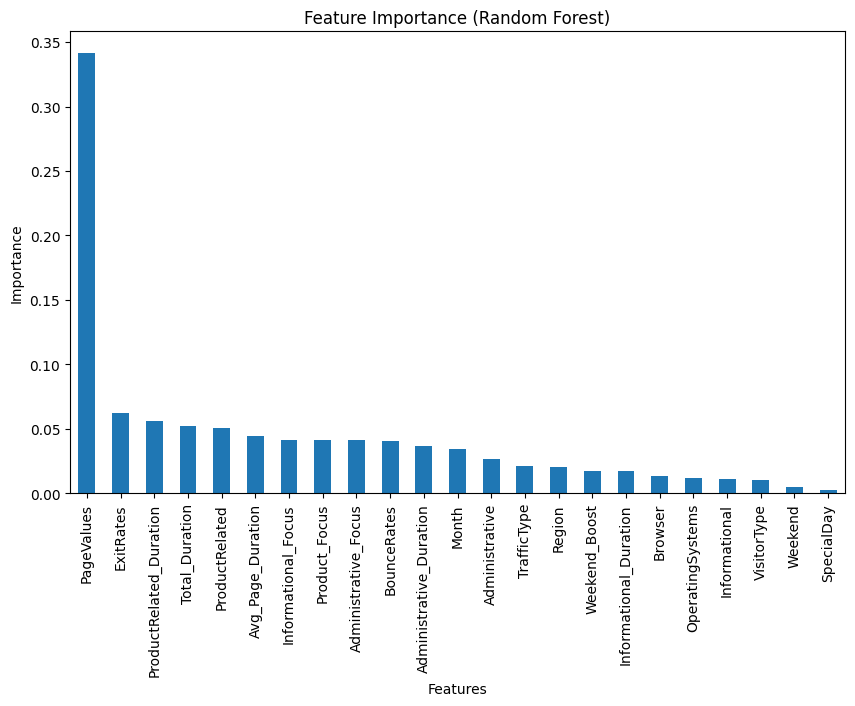

In [19]:
# Feature Importance (example using Random Forest)
X = dfShoppers_encoded.drop('Revenue', axis=1)
y = dfShoppers_encoded['Revenue']
model = RandomForestClassifier()
model.fit(X, y)
importances = model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()


Based on the Feature Imortance graph above, of the new features that were added, weekend boost does not seem to be as important as the other added features, therefore it will not be added to the dataset.

This graph also highlights the significance of 'PageValues', 'ExitRates', and 'ProductRelated' in predicting purchase behavior. This indicates that focusing on optimizing product pages, reducing bounce rates, and enhancing the overall product experience should be prioritized.

In [20]:
dfShoppers_encoded = dfShoppers_encoded.drop(['Weekend_Boost'], axis=1)
dfShoppers_encoded.head()


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,TrafficType,Weekend,Revenue,Month,VisitorType,Total_Duration,Avg_Page_Duration,Product_Focus,Informational_Focus,Administrative_Focus
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,1,False,False,2,2,-1.326469,0.743339,0.470684,0.184648,0.344668
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,...,2,False,False,2,2,-1.293024,0.733844,0.456993,0.189424,0.353583
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,3,False,False,2,2,-1.326469,0.743339,0.470684,0.184648,0.344668
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,...,4,False,False,2,2,-1.325076,0.752034,0.470127,0.184843,0.345030
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,...,4,True,False,2,2,-0.998552,0.631153,0.296860,0.245286,0.457854


In [21]:
print('Revenue Mean:')
print(np.mean(dfShoppers_encoded.loc[:,'Revenue']))

Revenue Mean:
0.15474452554744525


# **Model Building/Optimization**

In [22]:
# Select target as a series and features as dataframe
y = dfShoppers_encoded.loc[:,['Revenue']].values.ravel()
X = dfShoppers_encoded.drop(['Revenue'],axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8, test_size=0.2,random_state=1)

**Decision Tree:**

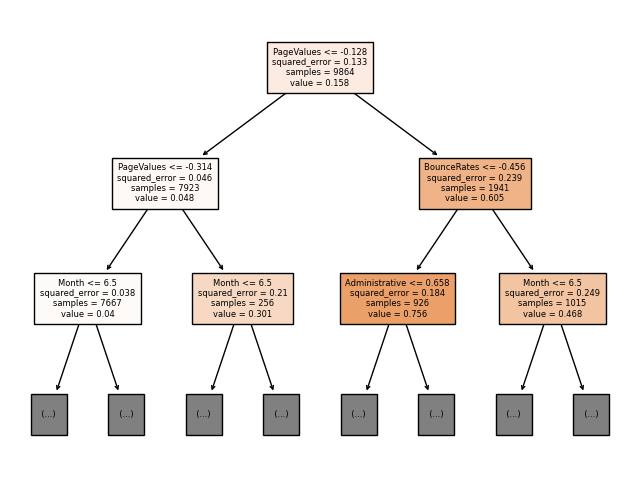

MAE:
0.14395782643957827


In [23]:
mdlDtrShoppers = DecisionTreeRegressor(random_state=1)
mdlDtrShoppers.fit(X_train, y_train)

plt.figure(figsize=(8, 6), dpi=100)
plot_tree(mdlDtrShoppers, max_depth=2, feature_names=X.columns, fontsize= 6, filled=True)
plt.show()

# Predict test data
y_test_pred = mdlDtrShoppers.predict(X_test)

# Evaluate test data actual vs prediction
print('MAE:')
print(mean_absolute_error(y_test,y_test_pred))

In [25]:
def get_mae(mx_lf_nds, X_trn, X_tst, y_trn, y_tst):
    mdlDtrShoppersDpt = DecisionTreeRegressor(max_leaf_nodes=mx_lf_nds, random_state=1)
    mdlDtrShoppersDpt.fit(X_trn,y_trn)
    y_tst_prd = mdlDtrShoppersDpt.predict(X_tst)
    mae = mean_absolute_error(y_tst, y_tst_prd)
    return(mae)

In [26]:
for i in [5, 50, 500, 50000]:
    mae = get_mae(i, X_train, X_test, y_train, y_test)
    print('Max leaf nodes: ',i, '\t Mean Absolute Error: ',mae)

Max leaf nodes:  5 	 Mean Absolute Error:  0.1495788823944926
Max leaf nodes:  50 	 Mean Absolute Error:  0.13480763675307122
Max leaf nodes:  500 	 Mean Absolute Error:  0.13653663190131696
Max leaf nodes:  50000 	 Mean Absolute Error:  0.13706407137064072


Optimal depth of the tree is at 50 max leaf nodes. However MAE is almost 87% of average revenue value, which is quite high therefore this is probably not the best model to use for this dataset.

**Linear Regression:**

In [27]:
# Define random forest model
mdlRfsShoppers = RandomForestRegressor(random_state=1)

# Fit model
mdlRfsShoppers.fit(X_train, y_train)

# Predict
y_test_pred = mdlRfsShoppers.predict(X_test)

# Evaluate
print('MAE (Random Forest):')
print(mean_absolute_error(y_test,y_test_pred))

MAE (Random Forest):
0.13761151662611518


MAE is approximately 89% of mean which is worst than MAE from decision tree. This is also not the ideal model for this dataset.

**XGBoost:**

In [28]:
#Build and score default Gradient Boosting Model
mdlXgbShoppers = XGBRegressor()
mdlXgbShoppers.fit(X_train, y_train)
y_test_pred = mdlXgbShoppers.predict(X_test)
mae = mean_absolute_error(y_test_pred, y_test)

print("MAE from default XGBoost model:")
print(mae)

MAE from default XGBoost model:
0.1473775


In [29]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
}

# Create XGBoost model
mdlXgbBFSales = XGBRegressor()

# Perform grid search with cross-validation
grid_search = GridSearchCV(mdlXgbBFSales, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_test_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test_pred, y_test)

print("Best parameters:", grid_search.best_params_)
print("MAE:", mae)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
MAE: 0.13602816


AE (87.9% of mean) is still worse than that from decision tree, even after hyperparameter tuning. Therefore, XGB is also not a auseful model for this situation.

**Logistic Regression:**


In [31]:
# Build Logistic Regression model
from sklearn.linear_model import LogisticRegression

mdlLgrShoppers = LogisticRegression(random_state=1)
mdlLgrShoppers.fit(X_train,y_train)
y_test_pred = mdlLgrShoppers.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
# Display model results using
from sklearn.metrics import confusion_matrix

print ('Confusion Matrix:')
print (confusion_matrix(y_test, y_test_pred))


Confusion Matrix:
[[2061   54]
 [ 220  131]]


In [33]:
# Display performance results
from sklearn.metrics import classification_report

print ('Classification Report (Logistic Regression):')
print (classification_report(y_test, y_test_pred))

# Display summary results
from sklearn.metrics import roc_auc_score

print ('AUC Score (Logistic Regression):')
print (roc_auc_score(y_test, y_test_pred))

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

       False       0.90      0.97      0.94      2115
        True       0.71      0.37      0.49       351

    accuracy                           0.89      2466
   macro avg       0.81      0.67      0.71      2466
weighted avg       0.88      0.89      0.87      2466

AUC Score (Logistic Regression):
0.673843729162878


In [34]:
param_grid_lgr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}

grid_search_lgr = GridSearchCV(mdlLgrShoppers, param_grid_lgr, cv=5, scoring='roc_auc')
grid_search_lgr.fit(X_train, y_train)

print("Best parameters for Logistic Regression:", grid_search_lgr.best_params_)
print("Best AUC score for Logistic Regression:", grid_search_lgr.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best AUC score for Logistic Regression: 0.8833440601629844


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression offers a very high AUC after hyperparameter tuning.

**Naive Bayes - Gaussian:**

In [24]:
# Build Naive Bayes - Gaussian model
mdlNbgShoppers = GaussianNB()
mdlNbgShoppers.fit(X_train,y_train)
y_test_pred = mdlNbgShoppers.predict(X_test)

print ('Results (Naive Bayes - Gaussian):\n')

print ('Classification Report:')
print (classification_report(y_test, y_test_pred))

print ('AUC Score (Naive Bayes - Gaussian):')
print (roc_auc_score(y_test, y_test_pred))

Results (Naive Bayes - Gaussian):

Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.88      0.90      2115
        True       0.45      0.59      0.51       351

    accuracy                           0.84      2466
   macro avg       0.69      0.74      0.71      2466
weighted avg       0.86      0.84      0.85      2466

AUC Score (Naive Bayes - Gaussian):
0.7355397951142632


AUC score is somewhat high but still not better than that from hyperparameter tuned logistic regression.

**K-Nearest Neighbor:**

In [35]:
# Build KNN model with 5 nearest neighbors
mdlKnnShoppers = KNeighborsClassifier(n_neighbors=10)
mdlKnnShoppers.fit(X_train, y_train)
y_test_pred = mdlKnnShoppers.predict(X_test)

print ('AUC Score (K-Nearest Neighbor):')
print (roc_auc_score(y_test, y_test_pred))

AUC Score (K-Nearest Neighbor):
0.6064011638479724


In [36]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search_knn = GridSearchCV(mdlKnnShoppers, param_grid_knn, cv=5, scoring='roc_auc')
grid_search_knn.fit(X_train, y_train)

print("Best parameters for KNN:", grid_search_knn.best_params_)
print("Best AUC score for KNN:", grid_search_knn.best_score_)

Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best AUC score for KNN: 0.8026181548232971


AUC score is high after hyperparameter tuning but still not better than logistic regression.

**Support Vector Machines - Classifier:**

In [37]:
# Build Support Vector Machines - Classifier model
mdlSvmShoppers = SVC()
mdlSvmShoppers.fit(X_train, y_train)
y_test_pred = mdlSvmShoppers.predict(X_test)

print ('Results (Support Vector Classifier):\n')

print ('Classification Report:')
print (classification_report(y_test, y_test_pred))

print ('AUC Score (Support Vector Classifier):')
print (roc_auc_score(y_test, y_test_pred))

Results (Support Vector Classifier):

Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.98      0.94      2115
        True       0.73      0.36      0.48       351

    accuracy                           0.89      2466
   macro avg       0.81      0.67      0.71      2466
weighted avg       0.88      0.89      0.87      2466

AUC Score (Support Vector Classifier):
0.6695641631811844


AUC is comparatively low for SVM Classifier


In [ ]:
#I attempted using the following code for hyperparameter tuning of the SVM model
#but it was taking too long and therefore could not execute in time!!!!

#param_grid_svm = {
#    'C': [0.1, 1, 10],
#    'kernel': ['linear', 'rbf', 'poly'],
#    'gamma': ['scale', 'auto']
#}

#grid_search_svm = GridSearchCV(mdlSvmShoppers, param_grid_svm, cv=5, scoring='roc_auc')
#grid_search_svm.fit(X_train, y_train)

#print("Best parameters for SVM:", grid_search_svm.best_params_)
#print("Best AUC score for SVM:", grid_search_svm.best_score_)


Logistic Regression, after hyperparameter tuning, emerges as the best-performing model with the highest AUC score. This suggests that it is most effective in distinguishing between purchasing and non-purchasing customers.

**In Conclusion:**

1. The Logistic Regression model can be used to predict the likelihood of a customer making a purchase based on their browsing behavior. This information can be leveraged for targeted marketing campaigns and personalized recommendations.

2. user experience can be improved by  investing in improving the design, content, and navigation of administrative and informational pages to encourage exploration and engagement.

3. Product pages should be enhanced because they stood out to be one of the more important features

4. Current efforts for feature engineering were limited, there may be room for improvement by building on this.
